# Reserve prices for revenue increase

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
import seaborn as sns

In [30]:
N_rounds = 1000
N_objects = 100
N_bidders = 130

budgets = np.array([  30.,   50.,   80.,  100.,  120.,  200.,  300.,  500., 1000.])
budgets_p = np.ones(9)/9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(N_bidders)])

fees = np.array([0, 0.3, 0.36, 0.68])
fees_p = np.array([0.36, 0.14, 0.30, 0.2])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(N_objects)])

auctioned_objects = np.array([AuctionedObject(i, 2.5, np.inf, fee=fees_init[i]) for i in range(N_objects)])
auctioneer = Auctioneer(auctioned_objects, x0 = np.ones(N_objects)*0)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(N_bidders)])

In [31]:
def myerson_rp(house):
    x0 = house.auctioneer.x0[house.auctioned_object.id_]
    dist = stats.lognorm(s=0.4, loc=-7, scale=16)
    fn = lambda r: r-(1-dist.cdf(r))/dist.pdf(r)-x0
    r_star = optimize.fsolve(fn, x0=0.3)
    return r_star

def rp_fees(house):
    obj_id = house.auctioned_object.id_
    x0 = house.auctioneer.x0[obj_id]
    fee = house.auctioned_object.fee
    r = fee*np.mean([house.winning_bid , house.second_bid]) + (1-fee)*x0
    return r 

house = AuctionHouse(N_rounds, 
                     auctioneer, 
                     bidders, 
                     rp_policy=myerson_rp
                    )

house.run()

In [32]:
df = house.bidder_tracker.make_dataFrame()

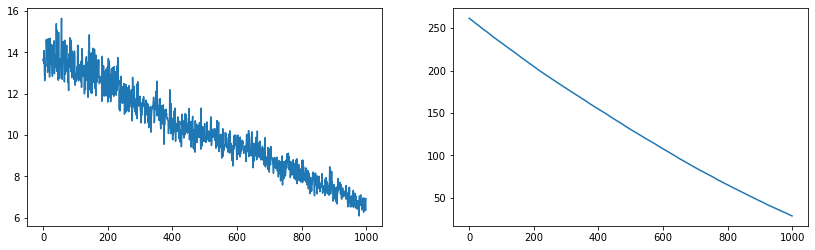

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))
df['bids'].mean(axis=1).plot(ax=ax1)
df['budgets'].mean(axis=1).plot(ax=ax2)

In [36]:
auc_df = house.auction_tracker.make_dataFrame()
auc_df

,object_id,winner,winning_bid,second_bid,payment,reserve_price,fee
auction_round,,,,,,,
0,93.0,36.0,37.115181,31.154306,31.154306,8.366133,0.00
1,84.0,9.0,47.605618,46.834529,46.834529,8.366133,0.68
2,51.0,44.0,43.786502,42.228301,42.228301,8.366133,0.36
3,64.0,44.0,35.805688,33.265402,33.265402,8.366133,0.36
4,20.0,44.0,34.976387,32.668874,32.668874,8.366133,0.00
...,...,...,...,...,...,...,...
995,0.0,13.0,32.975386,28.953621,28.953621,8.366133,0.00
996,7.0,13.0,18.403816,17.737587,17.737587,8.366133,0.30
997,94.0,24.0,31.155971,22.451831,22.451831,8.366133,0.36


# Throttling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from AuctionSimulator.Agents.Bidders import SimpleBidder
from AuctionSimulator.Agents.AuctionedObject import AuctionedObject, Auctioneer
from AuctionSimulator.Controllers import AuctionHouse

from AuctionSimulator.Policies.Throttling import Throttling

## test single policy

In [10]:
N_rounds = 1000
N_objects = 100
N_bidders = 130

budgets = np.array([  30.,   50.,   80.,  100.,  120.,  200.,  300.,  500., 1000.])
budgets_p = np.ones(9)/9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(N_bidders)])

fees = np.array([0, 0.3, 0.36, 0.68])
fees_p = np.array([0.36, 0.14, 0.30, 0.2])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(N_objects)])

throttling = Throttling(N_rounds, budgets_init, planning='uniform', probability='linear',
                        probability_kwargs={'floor': 0.})

In [12]:
auctioned_objects = np.array([AuctionedObject(i, 2, np.inf, fee=fees_init[i]) for i in range(N_objects)])
auctioneer = Auctioneer(auctioned_objects)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(N_bidders)])

house = AuctionHouse(N_rounds, 
                     auctioneer, 
                     bidders, 
                     rp_policy=None,
                     throttling=throttling
                    )

house.run()

In [13]:
df = house.bidder_tracker.make_dataframe()

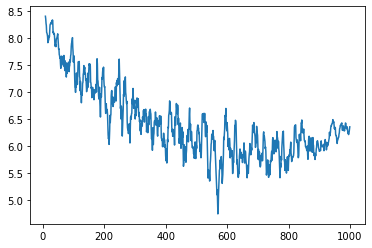

In [14]:
df['bids'].mean(axis=1).rolling(10).mean().plot()

## test multiple policies

In [2]:
def test_policy(throttling, fees_init, budgets_init):
    auctioned_objects = np.array([AuctionedObject(i, 1, np.inf, fee=fees_init[i]) for i in range(N_objects)])
    auctioneer = Auctioneer(auctioned_objects)
    bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(N_bidders)])

    house = AuctionHouse(N_rounds, 
                         auctioneer, 
                         bidders, 
                         rp_policy=None,
                         throttling=throttling,
                        )

    for i in range(N_rounds):
        obj_id = house.select_object_to_sell()
        house.sell_object(obj_id)
        
    return house

In [3]:
N_rounds = 1000
N_objects = 100
N_bidders = 130

budgets = np.array([30, 50, 80])
budgets_p = np.array([0.4, 0.4, 0.2])
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(N_bidders)])

fees = np.array([0, 0.3, 0.7])
fees_p = np.array([0.5, 0.25, 0.25])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(N_objects)])

uniform_throttling = Throttling(N_rounds, budgets_init)
sigmoid_throttling1 = Throttling(N_rounds, budgets_init, planning='sigmoid', planning_kwargs={'s':1, 't0':0.5})
sigmoid_throttling2 = Throttling(N_rounds, budgets_init, planning='sigmoid', planning_kwargs={'s':1, 't0':1})

throttling_policies = [uniform_throttling, sigmoid_throttling1, sigmoid_throttling2]
N_policies = len(throttling_policies)

In [4]:
%%time
N_days = 200
revenues_data = np.zeros((N_days, N_policies))
fees_paid_data = np.zeros((N_days, N_policies))

for thr, throttling in enumerate(throttling_policies):
    print('testing policy ', thr)
    for d in range(N_days):
        house = test_policy(throttling, fees_init, budgets_init)
        revenues_data[d, thr] = house.auctioneer.revenue
        fees_paid_data[d, thr] = house.auctioneer.fees_paid

testing policy  0


KeyboardInterrupt: 

In [8]:
throttling.total_probability??

Signature: throttling.total_probability(house)
Source:   
    def total_probability(self, house):
        """
        The bidder will not participate in the auction if their budget is below the current plan

        Parameters:
        house (object): An AuctionHouse object.
        """

        current_budgets = [b.budget for b in house.bidders]
        probabilities = np.where(current_budgets >= self.plan[house.counter], 1, 0)
        return probabilities
File:      c:\users\s2091069\pycharmprojects\auction simulator project\auctionsimulator\policies\throttling.py
Type:      method


In [5]:
revenues_data.mean(axis=0).round(2)

array([4690.59, 4758.36, 4746.35, 4790.12])

In [6]:
fees_paid_data.mean(axis=0).round(2)

array([1448.76, 1379.81, 1392.16, 1346.54])

# Fees reduction by dynamic reserve price

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from Auction_simulator.agents import AuctionedObject, Auctioneer, SimpleBidder, AuctionHouse
from Auction_simulator.trackers import AuctionTracker, BidderTracker
from Auction_simulator.auction_types import SecondPriceAuction

In [148]:
def rp_fees1(house):
    if house.auctioned_object.fee > 0:
        return np.mean([house.second_bid, house.winning_bid])
    else:
        return house.auctioneer.x0
    
def rp_fees2(house):
    fee = house.auctioned_object.fee
    r = fee*house.winning_bid + (1-fee)*house.second_bid
    return r 
    
def rp_fees3(house):
    fee = house.auctioned_object.fee
    r = fee*np.mean([house.winning_bid + house.second_bid]) + (1-fee)*house.auctioneer.x0
    return r 

In [149]:
def test_policy(rp_policy, fees_init, budgets_init):

    auctioned_objects = np.array([AuctionedObject(i, 1, np.inf, fee=fees_init[i]) for i in range(N_objects)])
    auctioneer = Auctioneer(auctioned_objects, x0=1)
    bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(N_bidders)])

    auction_tracker = AuctionTracker(N_rounds)
    bidder_tracker = BidderTracker(N_rounds, N_bidders, N_objects)
    house = AuctionHouse(auctioneer, bidders, 
                         rp_policy = rp_fees1,
                         auction_tracker=auction_tracker,
                         bidder_tracker=bidder_tracker
                        )

    for i in range(N_rounds):
        obj_id = house.select_object_to_sell()
        house.sell_object(obj_id)
        
    return house

In [150]:
N_rounds = 1000
N_objects = 100
N_bidders = 130

budgets = np.array([30, 50, 80])
budgets_p = np.array([0.4, 0.4, 0.2])
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(N_bidders)])

fees = np.array([0, 0.3, 0.7])
fees_p = np.array([0.5, 0.25, 0.25])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(N_objects)])

In [151]:
%%time

rp_policies = [None, rp_fees1, rp_fees2, rp_fees3]
rp_policies = [None]
N_policies = len(rp_policies)
N_days = 1
revenues_data = np.zeros((N_days, N_policies))
fees_paid_data = np.zeros((N_days, N_policies))

for rp, rp_policy in enumerate(rp_policies):
    print('testing policy ', rp)
    for d in range(N_days):
        house = test_policy(rp_policy, fees_init, budgets_init)
        revenues_data[d, rp] = house.auctioneer.revenue
        fees_paid_data[d, rp] = house.auctioneer.fees_paid

testing policy  0


AttributeError: 'int' object has no attribute 'size'

In [152]:
revenues_data.mean(axis=0).round(2)

array([0.])

In [8]:
fees_paid_data.mean(axis=0).round(2)

NameError: name 'fees_paid_data' is not defined